In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit_aer import AerSimulator
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from qiskit.utils import algorithm_globals
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import EstimatorQNN
import matplotlib.pyplot as plt
from IPython.display import clear_output
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit.algorithms.optimizers import COBYLA
import time

In [2]:
df = pd.read_csv('card_transdata.csv')
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [3]:
features = df.iloc[:,:-1]

In [4]:
labels = df.iloc[:,-1].to_numpy()
for i in range(len(labels)):
    labels[i] = 2 * labels[i] - 1
labels[:10]

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])

In [5]:
features = MinMaxScaler().fit_transform(features)

In [6]:
# !pip install imblearn
from imblearn.under_sampling import RandomUnderSampler


undersample = RandomUnderSampler(sampling_strategy='majority')
features_b, labels_b = undersample.fit_resample(features, labels)

In [7]:
algorithm_globals.random_seed = 42

train_features_b, test_features_b, train_labels_b, test_labels_b = train_test_split(
    features_b, labels_b, train_size=0.8, random_state=algorithm_globals.random_seed
)

train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

In [8]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

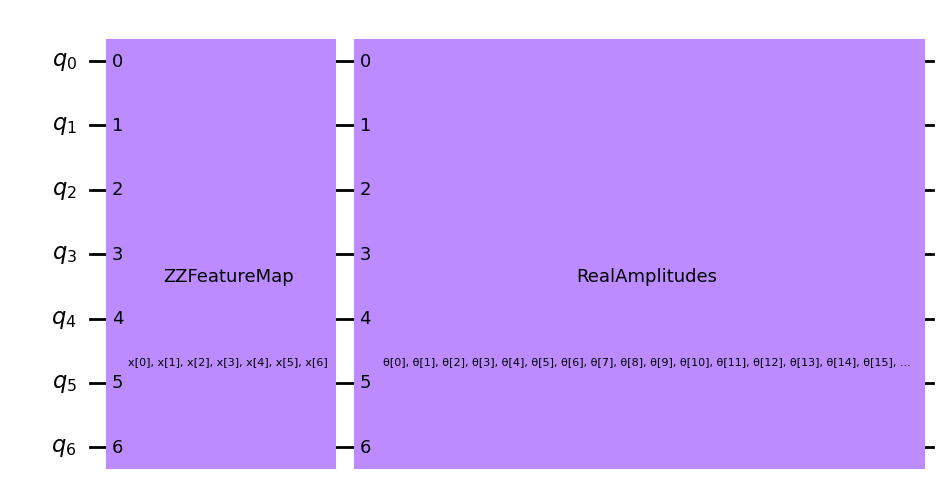

In [25]:
qc = QuantumCircuit(7)
feature_map = ZZFeatureMap(7)
ansatz = RealAmplitudes(7)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)
qc.draw(output="mpl")

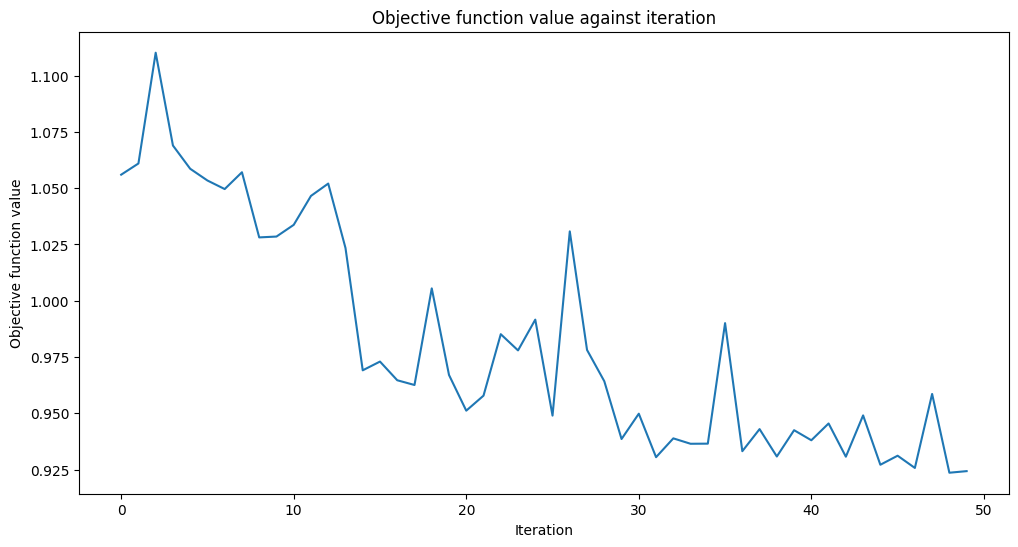

2583.7869622707367


In [29]:
estimator_qnn = EstimatorQNN(
    circuit=qc, input_params=feature_map.parameters, weight_params=ansatz.parameters
)

ec2 = NeuralNetworkClassifier(
    estimator_qnn, optimizer=COBYLA(maxiter=50), callback=callback_graph
)

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
start = time.time()
ec2.fit(train_features_b[:1000],train_labels_b[:1000])
end = time.time()
print(end-start)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

In [ ]:
ec2.score(test_features[:1000][test_labels[:1000] == -1],test_labels[:1000][test_labels[:1000] == -1])

0.4376344086021505

In [ ]:
ec2.score(test_features[:1000][test_labels[:1000] == 1],test_labels[:1000][test_labels[:1000] == 1])

0.7285714285714285

In [37]:
p = sum(test_labels[:1000] == 1)
n = 1000 - p
tn = int(n * 0.4376344086021505)
fp = n - tn
tp = int(p * 0.7285714285714285)
fn = p - tp
print(tn, fp, tp, fn)

407 523 51 19


In [38]:
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*precision*recall/(precision+recall)

print("Precision:", tp/(tp+fp))
print("Recall:", tp/(tp+fn))
print("F1:", f1)

Precision: 0.08885017421602788
Recall: 0.7285714285714285
F1: 0.15838509316770186


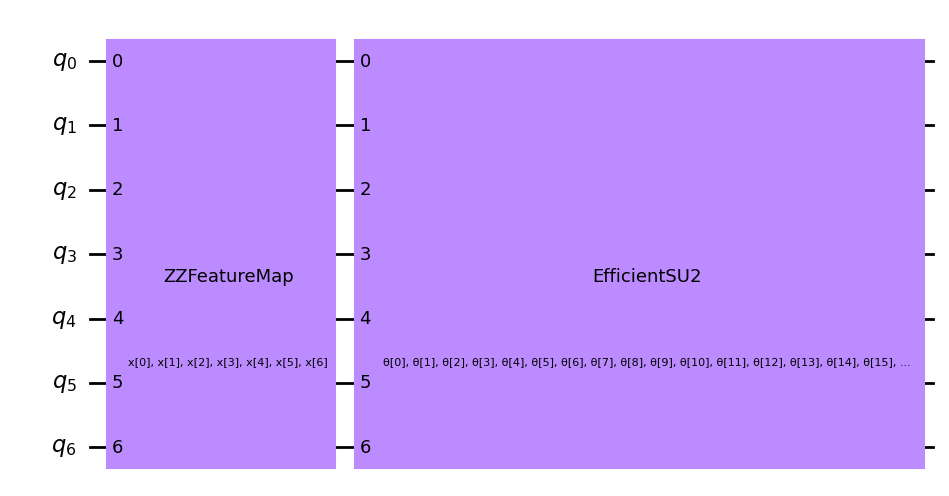

In [9]:
from qiskit.circuit.library import EfficientSU2

qc = QuantumCircuit(7)
feature_map = ZZFeatureMap(7)
ansatz = EfficientSU2(7)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)
qc.draw(output="mpl")

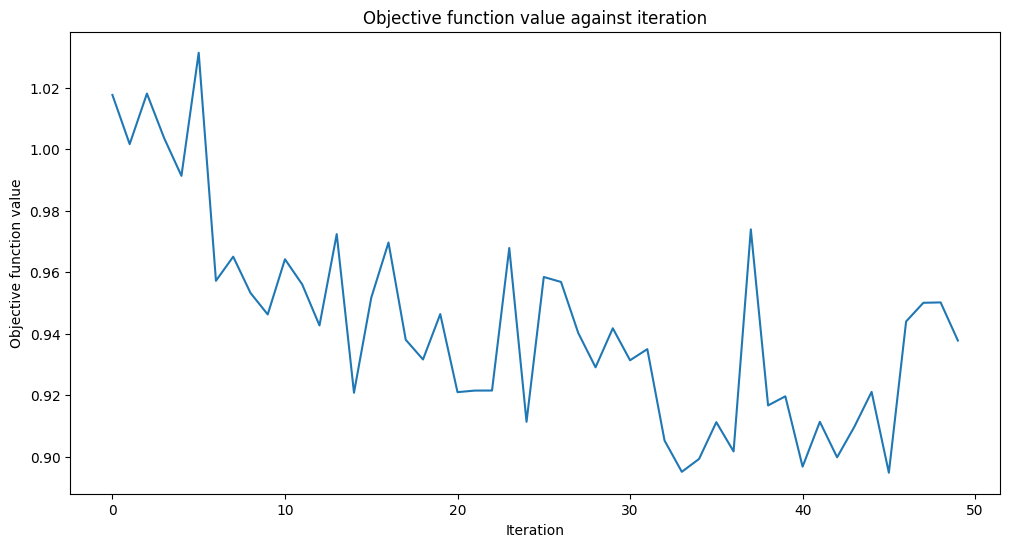

3482.710500240326
0.609


In [11]:
estimator_qnn = EstimatorQNN(
    circuit=qc, input_params=feature_map.parameters, weight_params=ansatz.parameters
)

ec2 = NeuralNetworkClassifier(
    estimator_qnn, optimizer=COBYLA(maxiter=50), callback=callback_graph
)

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
start = time.time()
ec2.fit(train_features_b[:1000],train_labels_b[:1000])
end = time.time()
print(end-start)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)
print(ec2.score(test_features[:1000],test_labels[:1000]))

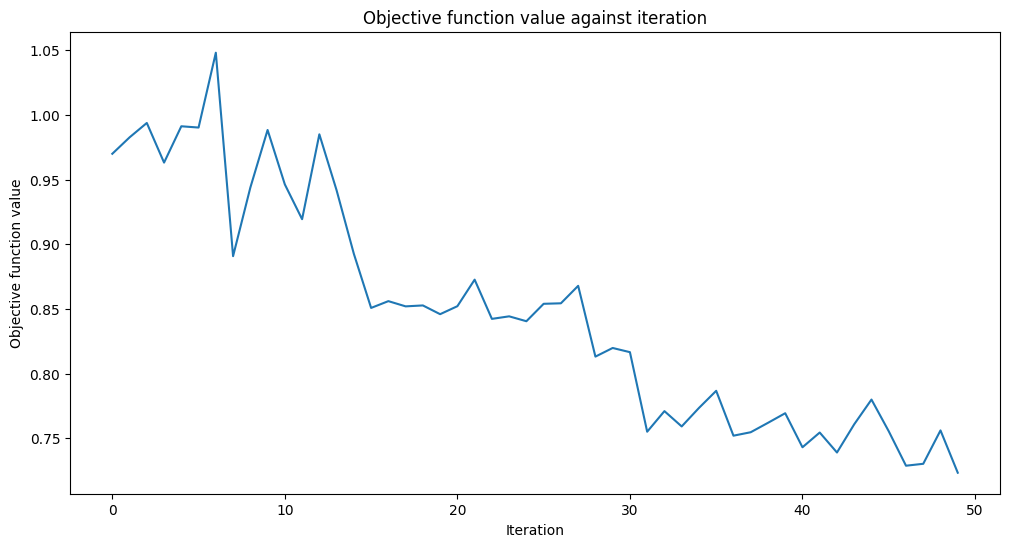

2419.2422597408295
0.755


In [12]:
qc = QuantumCircuit(7)
feature_map = ZZFeatureMap(7)
ansatz = RealAmplitudes(7, reps=1)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)

estimator_qnn = EstimatorQNN(
    circuit=qc, input_params=feature_map.parameters, weight_params=ansatz.parameters
)

estimator_classifier = NeuralNetworkClassifier(
    estimator_qnn, optimizer=COBYLA(maxiter=50), callback=callback_graph
)

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
start = time.time()
estimator_classifier.fit(train_features[:1000],train_labels[:1000])
end = time.time()
print(end-start)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)
print(estimator_classifier.score(test_features[:1000],test_labels[:1000]))